<h2>PROJET SANTE PUBLIQUE - Nettoyage des données<h2>

Nous importons des les packages dont nous avons besoin. A noter l'utilisation du package missingno permettant la visualisation des données manquantes

**Approche générale:**

Nous allons construiure une application de 'Health tracking' qui propose de scanner les aliments quotidiens qu'un utilisateur consomme quotidiennement. Notre application va donner une note à chacun des aliments. Ensuite, à la fin de la journée, l'utilisateur recevra une note concernant globale pour la journée, concernant sa nutrition. 

Nous allons faire ici l'étape de nettoyage des données. 

Ayant identifié les features cohérents avec notre application, nous avons identifiés les colonnes utiles de notre csv, et allons extraire ces colonnes. Notre travail de nettoyage se fera à partir de cette extraction.

In [1]:
import os
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'

Nous changons de working directory pour simplifier import et export

Nous lancons la lecture de notre fichier via Pandas. A noter que nous allons extraire directement les features qui nous interessent, 'used_features' ci-dessous. Cela aura l'avantage aussi d'être moins consommateur en mémoire, donc moins de temps de calcul.

Les données initiales sont sépararés par une tabulation.

In [2]:
filepath = '/Users/efkanturedi/Corteze/untitled folder/en.openfoodfacts.org.products.csv'
used_features = ['product_name','brands','code','pnns_groups_1','nutriscore_grade','energy-kcal_100g','proteins_100g','carbohydrates_100g','sugars_100g','fat_100g','saturated-fat_100g','fiber_100g','sodium_100g','nutrition-score-fr_100g']
data = pd.read_csv(filepath, sep='\t', usecols=used_features)

/Users/efkanturedi/opt/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pd.options.display.float_format = "{:.1f}".format

In [4]:
data.shape

(2059358, 14)

In [5]:
data.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
count,1583395.0,1625740.0,1577187.0,1625329.0,1604539.0,521335.0,1627049.0,1525942.0,731721.0
mean,68765490.2,73135898.6,63366.5,61513.4,62385492.1,188233574219299376079629544584801373126656.0,61428.4,26196.6,9.1
std,79770225977.6,86547118850.4,79573076.5,78385747.0,78945081868.5,135911288562437974396742564181811999933464576.0,78344304.1,32359270.4,8.9
min,0.0,0.0,0.0,-1.0,-1.0,-20.0,-500.0,0.0,-15.0
25%,100.0,0.8,0.1,3.5,0.6,0.0,1.3,0.0,1.0
50%,260.0,7.0,1.8,15.1,3.6,1.6,6.0,0.2,10.0
75%,400.0,21.2,7.1,53.0,17.5,3.6,12.5,0.6,16.0
max,100000000376832.0,110000001253376.0,99932728111.0,99932728111.0,100000000376832.0,98132750415618438665845168411918503733975056384.0,99932728111.0,39973091244.4,40.0


In [6]:
data.head()

,code,product_name,brands,nutriscore_grade,pnns_groups_1,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,endives,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,L.casei,NaN,NaN,unknown,NaN,1.4,0.9,9.8,9.8,NaN,2.7,0.0,NaN
2,0000000000017,Vitória crackers,NaN,NaN,unknown,375.0,7.0,3.1,70.1,15.0,NaN,7.8,0.6,NaN
3,0000000000031,Cacao,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,Filetes de pollo empanado,NaN,NaN,unknown,163.9,1.9,1.0,NaN,NaN,NaN,15.3,0.4,NaN


Nous voyons ici que notre jeu de données filtré contient beaucoup de NaN, soulignant un travail de nettoyage d'abord nécessaire de ce point de vue.

Dans le graphique ci-dessous, nous visualisons la complétude de nos features, et remarquons ainsi qu'ils sont plutôt non-NaN, excepté quatres features: additives_n, nutriscore_grade, fibre_100g, nutriscore-fr_100g

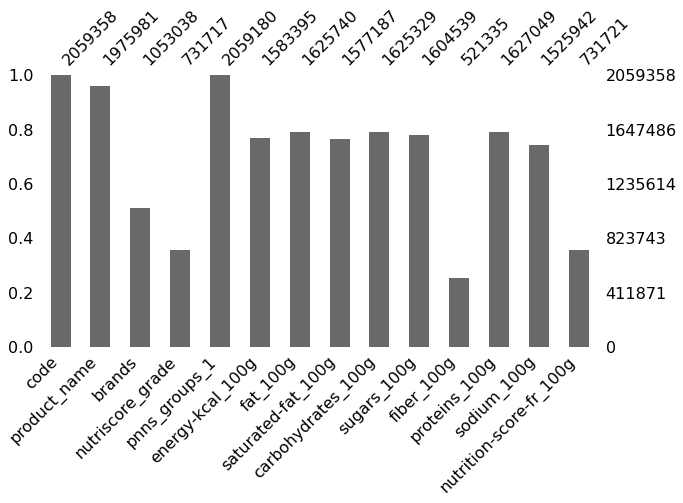

In [7]:
msno.bar(data, figsize=(10,5));

Nous créons une copie de notre jeu de données pour ne pas altérer le jeu initial

In [8]:
data_copy=data.copy(deep=True)

Nous savons que certaines features de notre base de données ont des caractérisques particulières. Beaucoup sont des valeurs comprises entre 0 et 100. Nous donnons le nom de "non_negative_capped_data" à ces features. Nous en profitons pour discuter les données numériques de manière générale

In [9]:
non_negative_capped_data = ['fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g']
numeric_data = ['energy-kcal_100g','fat_100g','saturated-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','nutrition-score-fr_100g']

Ci-dessous nous traitons les valeurs abérrantes de la facon suivante: 
- si un point de "non_negative_capped_data" est négatif, nous méttons sa valeur à 0 (valeur minimale légale)
- si un point de "non_negative_capped_data" est supérieur à 100, nous méttons sa valeur à 100 (valeur maximale légale)
- pour energy-kcal, nous limitons la valeur maximale à 3000kcal

In [10]:
for col in non_negative_capped_data:
    data_copy[col][data_copy[col] < 0] = 0
    data_copy[col][data_copy[col] > 100] = 100
data_copy['energy-kcal_100g'][data_copy['energy-kcal_100g'] > 1500] = 1500

In [11]:
data_copy[['sugars_100g','fiber_100g','proteins_100g','sodium_100g']].describe()

,sugars_100g,fiber_100g,proteins_100g,sodium_100g
count,1604539.0,521335.0,1627049.0,1525942.0
mean,13.0,3.1,8.7,0.6
std,19.4,5.3,10.0,3.1
min,0.0,0.0,0.0,0.0
25%,0.6,0.0,1.3,0.0
50%,3.6,1.6,6.0,0.2
75%,17.5,3.6,12.5,0.6
max,100.0,100.0,100.0,100.0


In [12]:
data_copy.shape

(2059358, 14)

In [13]:
data_copy.head()

,code,product_name,brands,nutriscore_grade,pnns_groups_1,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
0,00000000000000225,jeunes pousses,endives,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,L.casei,NaN,NaN,unknown,NaN,1.4,0.9,9.8,9.8,NaN,2.7,0.0,NaN
2,0000000000017,Vitória crackers,NaN,NaN,unknown,375.0,7.0,3.1,70.1,15.0,NaN,7.8,0.6,NaN
3,0000000000031,Cacao,NaN,NaN,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,Filetes de pollo empanado,NaN,NaN,unknown,163.9,1.9,1.0,NaN,NaN,NaN,15.3,0.4,NaN


Nous pouvons maintenant enlever les lignes de faible valeur ajoutée: ce sont les lignes dont les valeurs sont uniquement des NaNs.

In [14]:
new_data = data_copy.dropna(how='all',subset=numeric_data)
new_data = new_data.reset_index(drop=True)

In [15]:
new_data.tail()

,code,product_name,brands,nutriscore_grade,pnns_groups_1,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
1674606,9999999175305,Erdbeerkuchen 1019g tiefgefroren,Coppenrath & Wiese,d,Sugary snacks,NaN,7.6,4.8,35.0,24.0,NaN,2.6,0.1,12.0
1674607,99999995,Faux filet,NaN,a,Fish Meat Eggs,131.0,5.0,2.3,0.0,0.0,NaN,21.5,0.1,-2.0
1674608,9999999901,Scs,NaN,NaN,unknown,100.0,12.0,1.0,2.0,1.0,NaN,1.0,0.4,NaN
1674609,9999999990397,Fati,NaN,NaN,unknown,24.0,0.3,0.0,2.4,0.6,NaN,1.6,0.3,NaN
1674610,9999999999994,Light & Free SKYR A BOIRE,NaN,NaN,unknown,0.0,0.2,0.1,8.0,7.8,NaN,5.5,0.1,NaN


In [16]:
new_data.shape

(1674611, 14)

In [17]:
range(len(new_data.index))

range(0, 1674611)

In [18]:
ind = []
for value in range(len(new_data.index)):
   if new_data['product_name'].loc[value] == 'Eau':
      ind.append(value) 
new_data.loc[ind].head(20)

KeyboardInterrupt: 

In [ ]:
new_data = new_data.reset_index(drop=True)

Nous allons procéder à la préparation de l'utilisation de KNNImputer. Nous copions les données numériques dans un dataframe, et copions les valeurs numériques dans full_num

In [ ]:
secondary_data=new_data[:][['code','product_name','pnns_groups_1','nutriscore_grade']]
secondary_data = secondary_data.reset_index(drop=True)

In [ ]:
full_num = new_data[numeric_data]

In [ ]:
random_sample_full_num=full_num.sample(20000) 
random_sample_full_num

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
163903,548.0,28.6,19.1,64.3,61.9,0.0,4.8,0.2,27.0
475125,249.0,17.0,6.2,5.9,4.7,NaN,19.0,0.5,NaN
1359448,302.0,0.1,0.1,75.1,11.3,NaN,0.4,0.0,NaN
1284572,293.0,21.0,13.8,0.0,0.0,NaN,25.0,0.6,NaN
60736,571.0,46.4,5.4,21.4,7.1,7.1,25.0,0.2,9.0
...,...,...,...,...,...,...,...,...,...
681650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
211156,114.0,4.4,0.4,14.0,0.9,1.8,5.3,0.5,2.0
1245612,380.0,0.2,0.1,88.2,9.2,NaN,1.7,0.6,NaN
417494,167.0,0.0,0.0,40.0,33.3,0.0,0.0,0.0,9.0


Nous avons fait le choix de fitter notre modèle sur 20,000 lignes choisis de manière aléatoire pour alléger le temps de calcul dans le processus de transformation. Ainsi, nous obtenons data_Knned après 2h30 de temps de calcul

In [ ]:
imputer = KNNImputer(n_neighbors=3,algorithm='KDTree')
imputer.fit(random_sample_full_num)

KNNImputer(n_neighbors=3)

In [ ]:
data_Knned = imputer.transform(full_num)

In [ ]:
df = pd.DataFrame(data_Knned,columns = numeric_data)

In [ ]:
df.head()

,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
0,375.0,7.0,3.1,70.1,15.0,6.9,7.8,0.6,0.0
1,874.9,15.1,6.1,2.6,1.0,0.0,15.7,0.8,3.7
2,171.0,8.2,2.2,29.0,22.0,0.0,5.1,1.8,18.0
3,21.0,0.0,0.0,4.8,0.4,1.8,0.2,0.8,-3.0
4,60.0,3.0,1.0,10.0,3.0,1.6,2.0,0.5,0.0


Nous fusionnons les valeurs numériques aves le dataframe secondary_data

In [ ]:
final = pd.concat([secondary_data, df], axis=1)

In [ ]:
final

,code,product_name,pnns_groups_1,nutriscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
0,0000000000017,Vitória crackers,unknown,NaN,375.0,7.0,3.1,70.1,15.0,6.9,7.8,0.6,0.0
1,000000000004622327,Hamburguesas de ternera 100%,unknown,NaN,874.9,15.1,6.1,2.6,1.0,0.0,15.7,0.8,3.7
2,0000000000100,moutarde au moût de raisin,Fat and sauces,d,171.0,8.2,2.2,29.0,22.0,0.0,5.1,1.8,18.0
3,0000000000123,Sauce Sweety chili 0%,unknown,NaN,21.0,0.0,0.0,4.8,0.4,1.8,0.2,0.8,-3.0
4,0000000000178,Mini coco,unknown,NaN,60.0,3.0,1.0,10.0,3.0,1.6,2.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469657,9999999175305,Erdbeerkuchen 1019g tiefgefroren,Sugary snacks,d,46.7,7.6,4.8,35.0,24.0,2.0,2.6,0.1,12.0
1469658,99999995,Steak haché pur boeuf,Fish Meat Eggs,a,131.0,5.0,2.3,0.0,0.0,0.0,21.5,0.1,-2.0
1469659,9999999901,Scs,unknown,NaN,100.0,12.0,1.0,2.0,1.0,3.1,1.0,0.4,0.0
1469660,9999999990397,Fati,unknown,NaN,24.0,0.3,0.0,2.4,0.6,2.6,1.6,0.3,-0.7


In [ ]:
def grader_food(x):
        if x<=-1:
            return 'a'
        elif (x>-1)&(x<=2):
            return 'b'
        elif (x>2)&(x<=10):
            return 'c'
        elif (x>10)&(x<=18):
            return 'd'
        else:
            return 'e'

def grader_beverages(x):
        if (x<=0):
            return 'a'
        elif (x>0)&(x<=1):
            return 'b'
        elif (x>1)&(x<=5):
            return 'c'
        elif (x>5)&(x<=9):
            return 'd'
        else:
            return 'e'

In [ ]:
for ind in range(len(final.index)):
    if final['nutriscore_grade'].loc[ind] is np.nan:
        if final['pnns_groups_1'].loc[ind] == 'Beverages':
            final['nutriscore_grade'].loc[ind] = grader_beverages(final['nutrition-score-fr_100g'].loc[ind])
        else:
            final['nutriscore_grade'].loc[ind] = grader_food(final['nutrition-score-fr_100g'].loc[ind])

In [ ]:
final

,code,product_name,pnns_groups_1,nutriscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition-score-fr_100g
0,0000000000017,Vitória crackers,unknown,b,375.0,7.0,3.1,70.1,15.0,6.9,7.8,0.6,0.0
1,000000000004622327,Hamburguesas de ternera 100%,unknown,c,874.9,15.1,6.1,2.6,1.0,0.0,15.7,0.8,3.7
2,0000000000100,moutarde au moût de raisin,Fat and sauces,d,171.0,8.2,2.2,29.0,22.0,0.0,5.1,1.8,18.0
3,0000000000123,Sauce Sweety chili 0%,unknown,a,21.0,0.0,0.0,4.8,0.4,1.8,0.2,0.8,-3.0
4,0000000000178,Mini coco,unknown,b,60.0,3.0,1.0,10.0,3.0,1.6,2.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469657,9999999175305,Erdbeerkuchen 1019g tiefgefroren,Sugary snacks,d,46.7,7.6,4.8,35.0,24.0,2.0,2.6,0.1,12.0
1469658,99999995,Steak haché pur boeuf,Fish Meat Eggs,a,131.0,5.0,2.3,0.0,0.0,0.0,21.5,0.1,-2.0
1469659,9999999901,Scs,unknown,b,100.0,12.0,1.0,2.0,1.0,3.1,1.0,0.4,0.0
1469660,9999999990397,Fati,unknown,b,24.0,0.3,0.0,2.4,0.6,2.6,1.6,0.3,-0.7


In [ ]:
final.to_csv('openfoodfacts_clean_prod_new.csv', index=False)